# " Keep it Simple Stupid!"
# " Don't Repeat Yourself!"

# Writing a good function:
  
       -Sensibly named
      -Has a single responsibility
      -Includes a docstring
      -Returns a value
      -Is not longer than 50 lines
      -Is idempotent and, if possible , pure
  

In [1]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stat
import corner
import copy as Makecopy
import time

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

In [2]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [73]:
def Model_function(params):
    '''Return the model value given a,b,c, and x paramters'''
       
    x = np.arange(0, npix, 1, float)
    y = x[:,np.newaxis]
    
    n = noise
    X_a,Y_a,R_a,A_a = params[0],params[1],4,params[2]
    
    X_b,Y_b,R_b,A_b = params[3],params[4],4,params[5]
    
    #X_c,Y_c,R_c,A_c = params[6],params[7],4,params[8]
    
    source_template = tau(x,y,X_a,Y_a,R_a,A_a)+tau(x,y,X_b,Y_b,R_b,A_b) + n
    return source_template
    

def Log_Likelihood(data=None,sigma=None,model=None):
    
    '''Return the Log-Likelihood.
    lnLikelihood = sum(f(data|model,sigma^2))
                =-(n/2)*ln(2*pi) - (n/2)*ln(sigma^2) - (1/2*sigma^2)*sum((data-model)^2)    
    Keyword arguments:
    sigma -- noise level
    model    -- Model
    data     -- The data'''
    #Unit test for shape of data amd model
    assert data.shape == model.shape
    
    
    Term2 = -0.5*((1/sigma**2)*(data-model)**2)
    
    Log_Like = np.sum(Term2)
    
    return Log_Like

def prior_transform(u = None):
    '''Return the transformed prior space,array.'''
    
    x_a = u[0]*50        #10.0*u[0]+25
    y_a = u[1]*50             #10.0*u[1]+10
    a_a = u[2]*25
    
    x_b = u[3]*50                 #25.0*u[3]+100
    y_b = u[4]*50                       #15.0*u[4]+125
    a_b = u[5]*25
    
    '''x_c = u[6]*200                 #25.0*u[3]+100
    y_c = u[7]*200                       #15.0*u[4]+125
    a_c = u[8]*25'''
    
    return np.array([x_a,y_a,a_a,x_b,y_b,a_b])


def log_plus(x,y):
    '''Return the addition of x + y in log-space'''
    
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

In [102]:
noise_level = 1
Sources = 		pd.read_csv("/home/hope-moloko/Masters/Masters_Project/sources(200pix).csv")
ndim = 6
num_of_model_sources = 3

In [103]:
Sources

,Unnamed: 0,X,Y,R,A
0,0,98.834489,3.636768,4,22.330239
1,1,24.365604,115.999023,4,18.249551


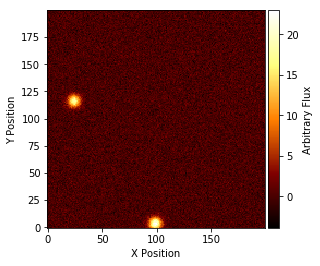

In [104]:
npix = 200
#################### Circularly Gaussian shaped  function ##################
def tau(x,y,X,Y,R,A):  #Circularly  Gaussian Shaped function
    term1 = ((x-X)**2 + (y-Y)**2)/(2*R**2)
    return A*np.exp(-term1)

########################### Source Image ###############################################
x = np.arange(0, npix, 1, float)
y = x [:,np.newaxis]

source1_template = np.zeros((npix,npix))
for i in range(len(Sources)):

    X_true = Sources['X'][i]
    Y_true = Sources['Y'][i]
    R_true = Sources['R'][i]
    A_true = Sources['A'][i]

    source1_template += tau(x,y,X_true,Y_true,R_true,A_true) 



# ADD noise of 2 units level

noise = np.random.normal(0,noise_level,source1_template.shape)
Data_Source = source1_template  + noise

ax = plt.subplot(111)

#ax.figure(figsize=(5,7))
im = ax.imshow(Data_Source,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')
plt.savefig('Image-200',bbox_inches='tight')

In [77]:
# Number of live points
num_of_live_points = 1000


#Save objects
points = np.zeros((num_of_live_points,ndim))

#log_likelihood of live objects
log_like_of_live_points = np.zeros((num_of_live_points))


#Generate Live objects
for i in range(num_of_live_points):
    points[i,:] = prior_transform(u=np.random.uniform(0,1.0,size=ndim))
    model = Model_function(params=points[i,:])
    log_like_of_live_points[i] = Log_Likelihood(data=Data_Source,sigma=noise,model=model)


In [78]:
nest = 50000
keep = np.zeros((nest,ndim))  #store bad points
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   


logWT = []  #Store  weight =width*likelihood


logZ = -1e300     # SUM(weights)= Z Evidence
H = 0


In [80]:
# Defined intervals for each parameters
Flat_interval = [(0,50),(0,50),(0,25),(0,50),(0,50),(0,25)]   #,(0,200),(0,200),(0,25)]
mcmc_steps = 50
Acceptance = np.empty((nest))

In [81]:
progressor = IntProgress(
    value=0,
    min=0,
    max=nest,
    step=1,
    description='Loading:',
    bar_style='success',
    orientation='horizontal'
) # instantiate the bar
display(progressor)
## MAIN NS LOOP##

#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / num_of_live_points))

start = time.time()
for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(log_like_of_live_points)
    
    #Save worst opbject
    keep[i,:] = points[worst,:]
    logl_sample.append(log_like_of_live_points[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + log_like_of_live_points[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = np.logaddexp(logZ,logwt)     #CHANGED THIS LINE
    
    #Update H information
    H = np.exp(logwt-logZnew)*log_like_of_live_points[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/num_of_live_points
    

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(points))
        if (copy != worst):break
            
    points[worst,:] = Makecopy.deepcopy(points[copy,:])
    log_Likelihood_old =  log_like_of_live_points[copy]
    
    theta = points[copy,:]
    
    #UNIT TEST check for correct shape
    assert theta.shape == (ndim,)
    
   # initialize mcmc params
    
    scale = 1.0
    accept = 0
    reject = 0
    for mcmci in range(mcmc_steps):  #Evolve within current worst likelihood L>L* , draw new point under constraint
    #while True:   
        propose_step = np.random.normal(0,scale=scale,size=ndim)
        new_point = theta + propose_step
        
        
        add = 0
        for j in range(len(theta)):
                if Flat_interval[j][0] <= new_point[j] <= Flat_interval[j][1]:
                    add += 1
                else:
                    pass

        if add == len(theta):
            Prior = 1
        else:
            Prior = 0
        
        #Calculate Log_likelihood of new point
        model = Model_function(params=new_point)
        
        #Ignore divde by zero runtimewarining
        np.seterr(divide='ignore')
        log_Likelihood_new = Log_Likelihood(data=Data_Source,sigma=noise,model=model) + np.log(Prior)
       
    
        #Acceptance ratio alpha
        alpha = np.exp(log_Likelihood_new-log_Likelihood_old)
        
        
        if alpha>=1:
            points[worst,:] = new_point  #Replace worst point with new point
            log_like_of_live_points[worst] = log_Likelihood_new   #Replace the worst likelihood with new one  
            accept += 1
            break
            
        else:
            u = np.random.uniform()
            if u <= alpha :
                points[worst,:] = new_point 
                log_like_of_live_points[worst] = log_Likelihood_new
                accept += 1
                break
                
            else:
                theta = theta
                reject +=1
                
        #Changing the scale
        if accept > reject:
            scale *= np.exp(1./accept)
        if accept < reject:
            scale /= np.exp(1./reject)

    
    Acceptance_Ratio = accept/(accept+reject)
    Acceptance[i] =  Acceptance_Ratio
    
    progressor.value += 1
    
                
    if i >nest*np.exp(H)/np.log(2.):
        break

end = time.time()
if progressor.value == progressor.max:
    progressor.description = "Done!"
    
Z = logZ
Z_err = np.sqrt((H)/num_of_live_points)
H = H        #np.exp(H)/np.log(2.)
#print("Acceptance Ratio :",Acceptance_Ratio)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))
print('time:',end-start)

IntProgress(value=0, bar_style='success', description='Loading:', max=50000)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Evidence Z = -33.19437368030429 +-0.1644536813186015 : Information H = 27.04501329924014 
time: 239.04028272628784


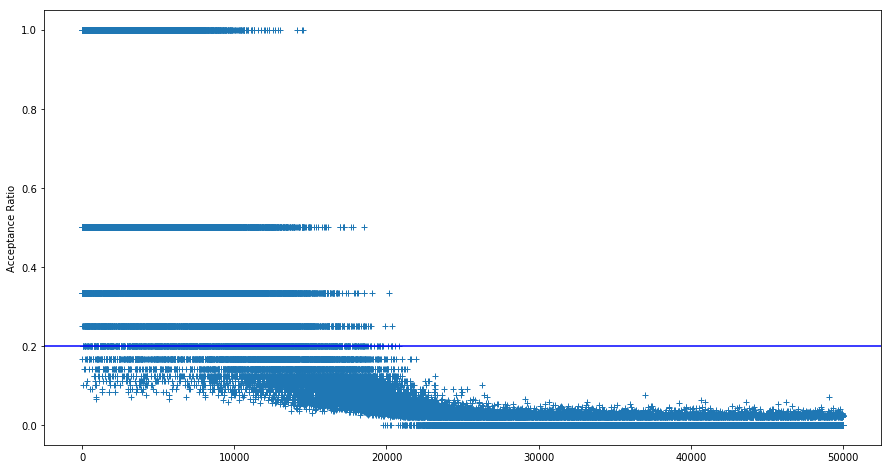

In [82]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(0,len(Acceptance)),Acceptance,'+')
plt.ylabel('Acceptance Ratio')
plt.axhline(0.2,c='blue')

In [83]:
#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#Effective sample size
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights+1e-300))))
S = 0
sample = np.zeros((effective_sample_size,ndim))


print('Effective Sample Size : {}'.format(effective_sample_size))

#Progress bar
progressor_samples = IntProgress(
    value=0,
    min=0,
    max=effective_sample_size,
    step=1,
    description='Loading:',
    bar_style='success',
    orientation='horizontal'
) # instantiate the bar
display(progressor_samples)

# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    #proba = prob_weighted[rnd_point]/max(prob_weighted)
    proba = Weights[rnd_point]/max(Weights)

    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        
        S += 1
        progressor_samples.value += 1
    if S >= effective_sample_size:
        break


Effective Sample Size : 6664


IntProgress(value=0, bar_style='success', description='Loading:', max=6664)

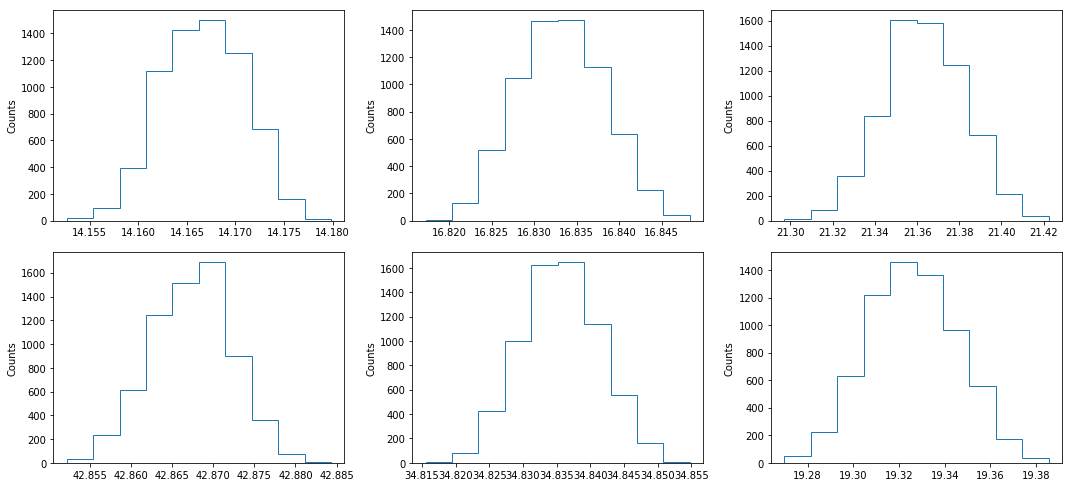

In [86]:
plt.figure(figsize=(15,10))

ndim = 6
#labels = ['x','y','a','x$_{1}$','y$_{1}$','a$_{1}$']
#truth =  [32.4,18.82,9.03,120.5,129.3,13.15]
for i in range(ndim):
    plt.subplot(3,3,i+1)
    plt.hist(sample[:,i],histtype="step")
    #plt.xlabel(labels[i])
    plt.ylabel('Counts')
    #plt.axvline(truth[i])

plt.tight_layout()
    

In [87]:
Sources

,Unnamed: 0,X,Y,R,A
0,0,42.867227,34.835931,4,19.327570
1,1,14.166760,16.832976,4,21.365226


In [88]:
import corner 

<Figure size 1080x576 with 0 Axes>

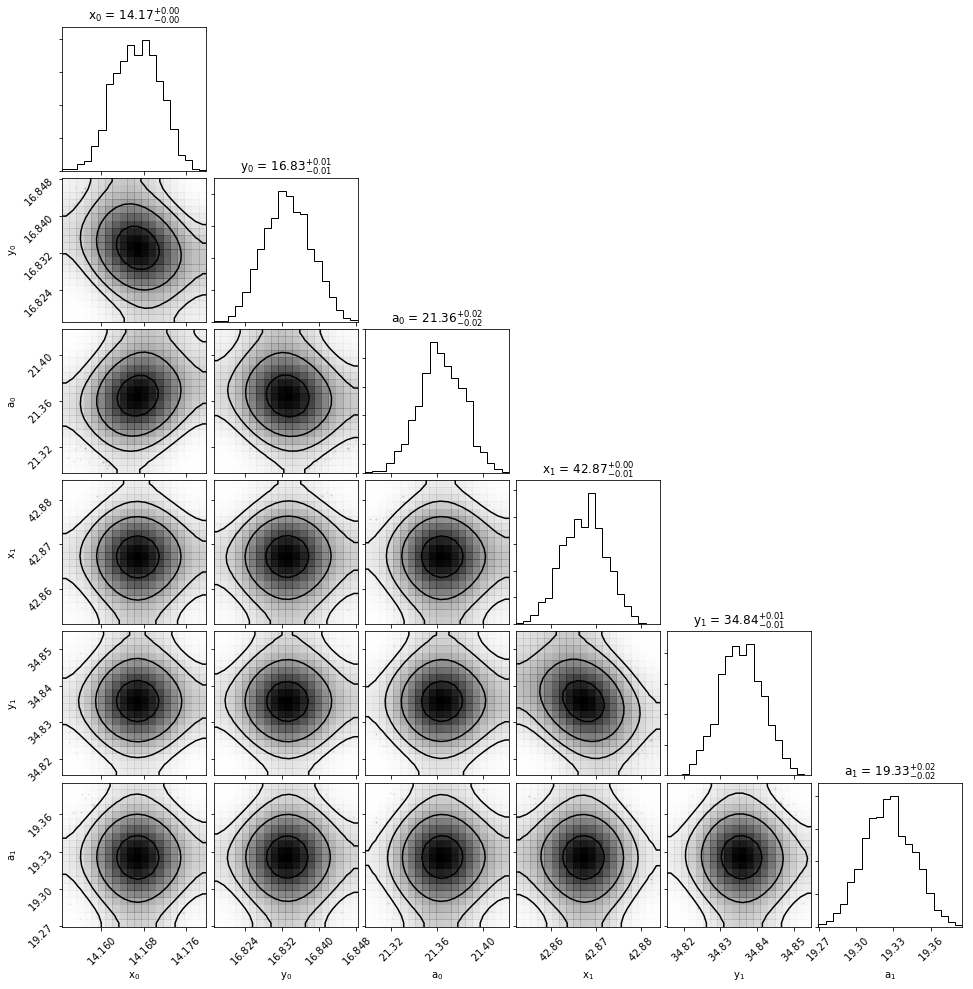

In [90]:
plt.figure(figsize=(15,8))
fig = corner.corner(sample,labels=['x$_{0}$','y$_{0}$','a$_{0}$','x$_{1}$','y$_{1}$','a$_{1}$','x$_{1}$','y$_{1}$','a$_{1}$'],show_titles=True,smooth=5,use_math_text=True,max_n_ticks=4,truth_color='blue')
#plt.title('Weigthed Posterior')

plt.savefig('Posterior-50',bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,15))
ax = plt.gca()
ellipses = []
plt.xlim([0,npix])
plt.ylim([0,npix])
X_pos = [32.41,120.55]
Y_pos = [18.83,129.38]
for ra, dec in zip(X_pos,Y_pos):
    ellipse = Ellipse(xy=(ra, dec), width=5, height=5, angle=0)
    ellipses.append(ellipse)

p = PatchCollection(ellipses)
ax.add_collection(p)
im = ax.imshow(Data_Source,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')
#plt.savefig('Image_Found',bbox_inches='tight')